In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import month_plot, quarter_plot,\
                                           plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
                            root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel

In [4]:
df = pd.read_csv('electricity.csv', index_col='ds', parse_dates=True)
df = df.query('unique_id == "DE"')
df = df.asfreq('h')
df

,unique_id,y,Exogenous1,Exogenous2
ds,,,,
2017-10-22 00:00:00,DE,19.10,587.25,16972.75
2017-10-22 01:00:00,DE,19.03,623.00,16254.50
2017-10-22 02:00:00,DE,16.90,650.00,15940.25
2017-10-22 03:00:00,DE,12.98,687.25,15959.50
2017-10-22 04:00:00,DE,9.24,717.25,16071.50
...,...,...,...,...
2017-12-30 19:00:00,DE,16.18,1519.50,19326.00
2017-12-30 20:00:00,DE,11.13,1526.75,18135.25
2017-12-30 21:00:00,DE,4.62,1514.75,17631.50


Exploratory Data Analysis

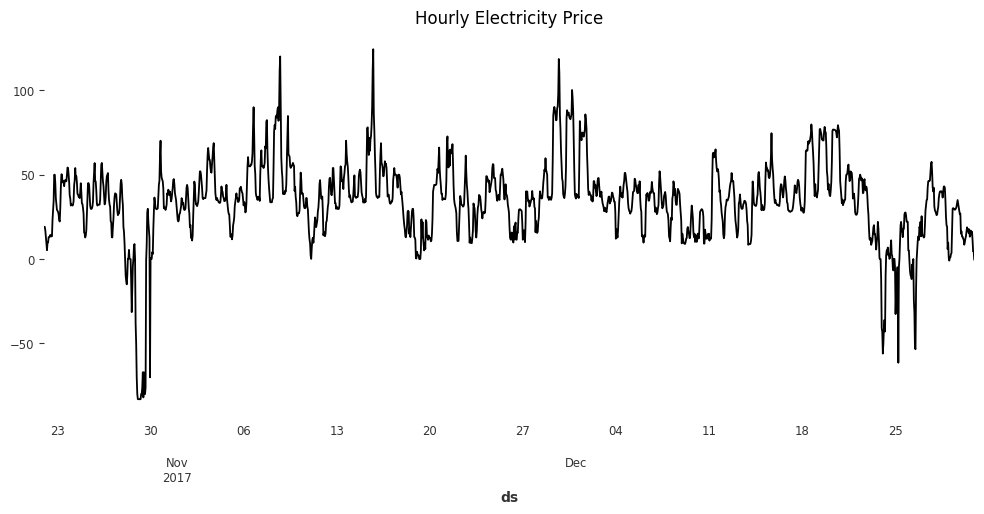

In [5]:
fig = plt.figure(figsize=(12, 5))
df['y'].plot(title='Hourly Electricity Price')
plt.grid('')
plt.show()

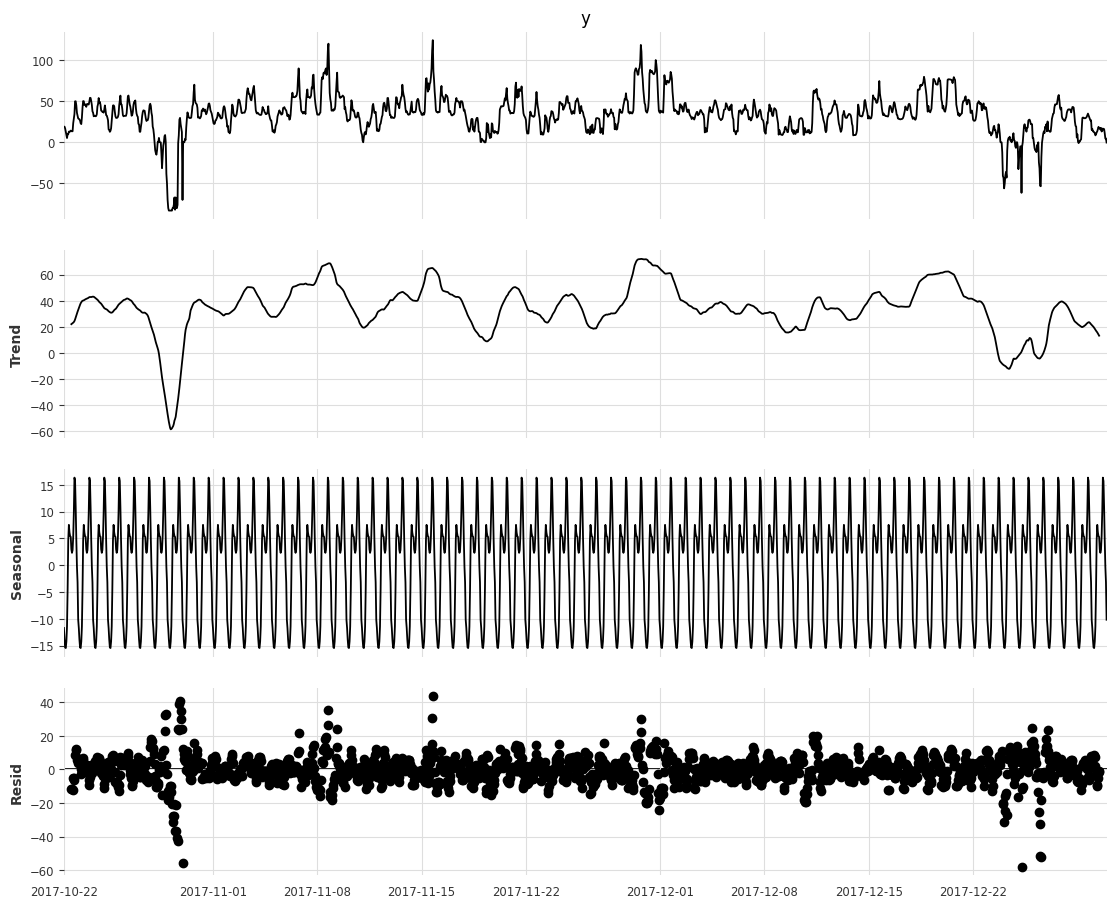

In [6]:
decomposition = seasonal_decompose(df['y'], model='add', period=24)


fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.show()

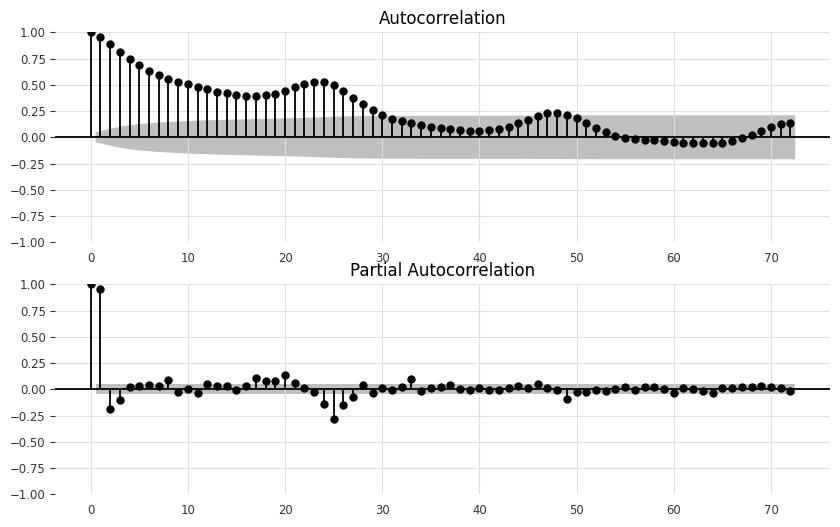

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(df['y'], lags=72, ax=ax[0])
plot_pacf(df['y'], lags=72, ax=ax[1])
plt.show()

In [8]:
series = TimeSeries.from_dataframe(df, value_cols='y')
series

<TimeSeries (DataArray) (ds: 1680, component: 1, sample: 1)> Size: 13kB
array([[[19.1 ]],

       [[19.03]],

       [[16.9 ]],

       ...,

       [[ 4.62]],

       [[ 4.71]],

       [[-0.27]]])
Coordinates:
  * ds         (ds) datetime64[ns] 13kB 2017-10-22 ... 2017-12-30T23:00:00
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [9]:
def encode_year(idx):
    return(idx.year - 2000) / 50

add_encoders = {
    'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']},
    'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [encode_year], 'future': [encode_year]},
    'transformer': Scaler(),
    'tz': 'CET'}

Past Covariates

In [10]:
X_past = df.iloc[:, 2:]
past_covariates = TimeSeries.from_dataframe(X_past)

past_covariates

<TimeSeries (DataArray) (ds: 1680, component: 2, sample: 1)> Size: 27kB
array([[[  587.25],
        [16972.75]],

       [[  623.  ],
        [16254.5 ]],

       [[  650.  ],
        [15940.25]],

       ...,

       [[ 1514.75],
        [17631.5 ]],

       [[ 1484.75],
        [17553.75]],

       [[ 1440.75],
        [16754.5 ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 13kB 2017-10-22 ... 2017-12-30T23:00:00
  * component  (component) object 16B 'Exogenous1' 'Exogenous2'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Future Covariates

In [11]:
future_df = pd.read_csv('electricity-future.csv', 
                        index_col='ds', 
                        parse_dates=True)

future_df = future_df.query('unique_id == "DE"')
X_future = future_df.iloc[:, 1:]

X = pd.concat([X_past, X_future])

future_covariates = TimeSeries.from_dataframe(X)

In [12]:
scaler_y = Scaler()
scaler_covariates = Scaler()

y_transformed = scaler_y.fit_transform(series)

past_covariates_transformed = scaler_covariates.fit_transform(past_covariates)
future_covariates_transformed = scaler_covariates.fit_transform(future_covariates)

TFT Model

In [13]:
model = TFTModel(
    input_chunk_length = 96,
    output_chunk_length = 24,
    hidden_size = 16,
    lstm_layers = 2,
    num_attention_heads = 4,
    dropout = 0.1,
    batch_size = 64,
    n_epochs = 10,
    add_encoders = add_encoders,
    use_static_covariates = True,
    pl_trainer_kwargs = {'accelerator': 'cpu'}
)

model.fit(
    y_transformed,
    past_covariates = past_covariates_transformed,
    future_covariates = future_covariates_transformed
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       | _Vari

Epoch 9: 100%|██████████| 25/25 [00:03<00:00,  6.30it/s, train_loss=0.251]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:03<00:00,  6.30it/s, train_loss=0.251]


TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=2, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=96, output_chunk_length=24, batch_size=64, n_epochs=10, add_encoders={'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x7f41d4e54720>], 'future': [<function encode_year at 0x7f41d4e54720>]}, 'transformer': Scaler, 'tz': 'CET'}, pl_trainer_kwargs={'accelerator': 'cpu'})

Cross-Validation

In [15]:
cv = model.historical_forecasts(
    series = y_transformed,
    past_covariates = past_covariates_transformed,
    future_covariates = future_covariates_transformed,
    forecast_horizon = 24,
    start = df.shape[0] - 240,
    retrain = True,
    stride = 24,
    last_points_only = False
)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork   

Epoch 9: 100%|██████████| 21/21 [00:03<00:00,  6.15it/s, train_loss=0.474]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 21/21 [00:03<00:00,  6.15it/s, train_loss=0.474]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn         

Epoch 9: 100%|██████████| 22/22 [00:03<00:00,  5.99it/s, train_loss=0.223]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:03<00:00,  5.99it/s, train_loss=0.223]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn         

Epoch 9: 100%|██████████| 22/22 [00:03<00:00,  5.71it/s, train_loss=0.268]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:03<00:00,  5.71it/s, train_loss=0.268]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn         

Epoch 9: 100%|██████████| 22/22 [00:03<00:00,  6.12it/s, train_loss=0.335]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:03<00:00,  6.12it/s, train_loss=0.335]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn         

Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.24it/s, train_loss=0.304]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.24it/s, train_loss=0.304]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn         

Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.18it/s, train_loss=0.307]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.18it/s, train_loss=0.307]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn         

Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.08it/s, train_loss=0.275]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.08it/s, train_loss=0.275]


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | inpu

Epoch 9: 100%|██████████| 24/24 [00:03<00:00,  6.23it/s, train_loss=0.348]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:03<00:00,  6.23it/s, train_loss=0.348]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn         

Epoch 9: 100%|██████████| 24/24 [00:03<00:00,  6.12it/s, train_loss=0.300]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:03<00:00,  6.12it/s, train_loss=0.300]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn         

Epoch 9: 100%|██████████| 25/25 [00:04<00:00,  6.24it/s, train_loss=0.194]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:04<00:00,  6.24it/s, train_loss=0.194]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [16]:
rmse_cv = []

for i in range(len(cv)):

    predictions = TimeSeries.pd_series(scaler_y.inverse_transform(cv[i]))

    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df['y'][start:end]

    error_cv = root_mean_squared_error(actuals, predictions)
    rmse_cv.append(error_cv)

np.average(rmse_cv)

27.064470845244433

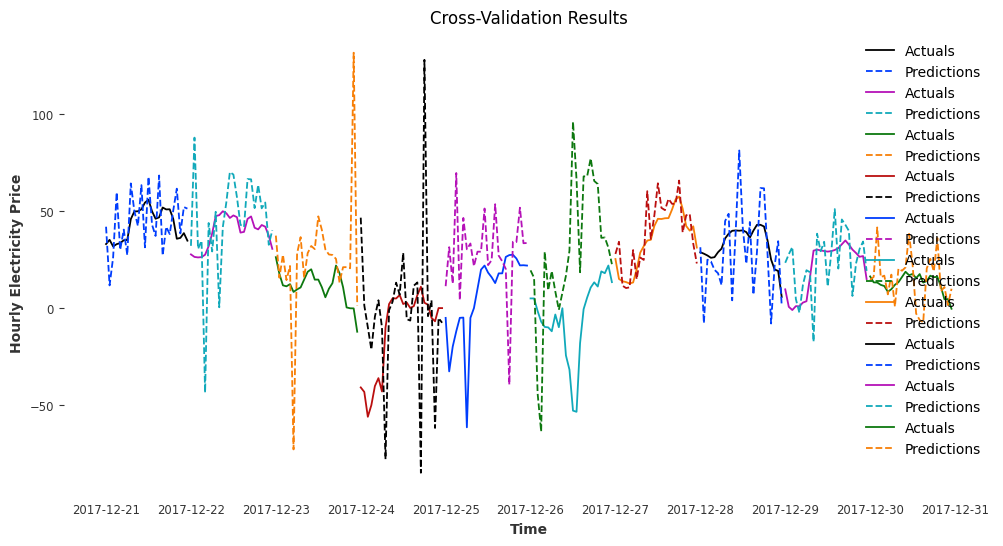

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(len(cv)):

    predictions = TimeSeries.pd_series(scaler_y.inverse_transform(cv[i]))

    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df['y'][start:end]

    ax.plot(actuals, label='Actuals')
    ax.plot(predictions, label='Predictions', linestyle='dashed')

ax.set_xlabel('Time')
ax.set_ylabel('Hourly Electricity Price')
ax.set_title('Cross-Validation Results')

ax.legend()
plt.grid('')
plt.show()
